In [1]:
import pandas as pd
import math
from pandas.io import gbq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from datetime import timedelta
import os
%matplotlib inline

In [2]:
pd.set_option('display.max_info_columns',200)
pd.set_option('display.max_colwidth',200)

## Importing and Processing the Data

Data and original project details can be found [here](https://osf.io/59uyz/wiki/home/).

In [3]:
os.chdir("../data")

In [4]:
df_g = pd.read_csv('G_raw.csv')
df_g['topic']='G' #Adding a topic column to backout the context of the tweet in the future
df_m = pd.read_csv('M_raw.csv')
df_m['topic']='M'
df_c = pd.read_csv('C_raw.csv')
df_c['topic']='C'

In [5]:
df_g.loc()[5]

id_str                                                                                                                                               661664598429331456
timestamp                                                                                                                                           2015-11-03 22:01:48
retweeted_status.id_str                                                                                                                                      6.6165e+17
user.id_str                                                                                                                                                    18558809
user.screen_name                                                                                                                                           koolkat14215
user.location                                                                                                                                           Paradise

## Cleaning Merged Dataframe

In [6]:
df=df_g.append(df_m).append(df_c) #Merging the three topic dataframes

In [7]:
bins = [-5, -.7, -.1, .1, .7, 5] #Defining ideology bins for users
bin_names = ['strong_liberal', 'slight_liberal', 'non_partisan', 'slight_conservative', 'strong_conservative']
df['ideo_bin'] = pd.cut(df['ideology'], bins, labels=bin_names)

In [8]:
df['retweeted_status.id_str']=df['retweeted_status.id_str'].map(lambda x: '{:.0f}'.format(x))
df['retweeted_status.id_str']=df['retweeted_status.id_str'].astype(str) #Formatting the retweet id field
df['id_str']=df['id_str'].map(lambda x: '{:.0f}'.format(x))
df['id_str']=df['id_str'].astype(str) #Formatting the tweet id field

In [9]:
df_retweets=df[['ideo_bin','retweeted_status.id_str']].groupby(['retweeted_status.id_str','ideo_bin']).size().reset_index()
#Creating a retweets dataset to count retweets (engagement) by ideology bin of retweeter

In [10]:
df=df[df['retweeted_status.id_str'] == 'nan'] #removing retweets from the dataset

In [11]:
df=df.reset_index(drop=True)

In [12]:
df=df[df['text'].str.match('RT @')==False] #removing retweets from the dataset that were not correctly labeled

In [13]:
df_retweets.columns = ['tweet_id', 'ideo_bin', 'retweets']

In [14]:
df_retweets=df_retweets.pivot(index='tweet_id', columns='ideo_bin', values='retweets').fillna(0)

In [15]:
df_w_rt = pd.merge(left=df, right=df_retweets, how='left', left_on='id_str', right_index=True)

In [16]:
df_w_rt.update(df_w_rt[['strong_liberal', 'slight_liberal', 'non_partisan', 'slight_conservative', 'strong_conservative']].fillna(0))
df_w_rt.rename(columns={'strong_liberal': 'strong_liberal_rts', 'slight_liberal': 'slight_liberal_rts', 'non_partisan': 'non_partisan_rts', 'slight_conservative': 'slight_conservative_rts', 'strong_conservative': 'strong_conservative_rts'}, inplace=True)

In [17]:
df_w_rt['retweets']=df_w_rt['strong_liberal_rts']+df_w_rt['slight_liberal_rts']+df_w_rt['non_partisan_rts']+df_w_rt['slight_conservative_rts']+df_w_rt['strong_conservative_rts']

In [18]:
del df_w_rt['retweeted_status.id_str']

## Merged Dataframe Visualizations

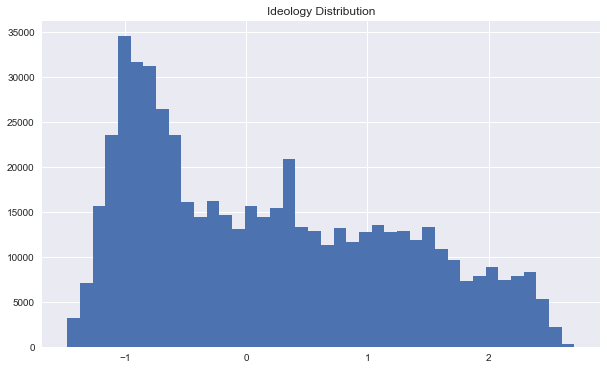

In [19]:
plt.figure(figsize=(10,6))
plt.hist(df_w_rt['ideology'], bins=40)
plt.title('Ideology Distribution')
plt.show()

In [20]:
df_w_rt['log_followers']=np.log(df_w_rt['user.followers_count'])

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [21]:
df_w_rt['log_followers']=df_w_rt['log_followers'].replace(-np.inf, 0)

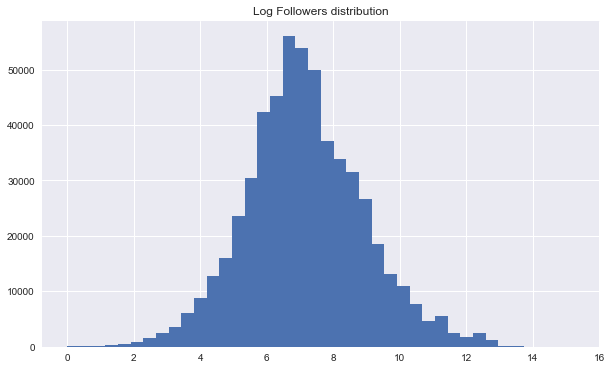

In [22]:
plt.figure(figsize=(10,6))
plt.hist(df_w_rt['log_followers'], bins=40)
plt.title('Log Followers distribution')
plt.show()

In [23]:
df_w_rt['log_retweets']=np.log(df_w_rt['retweets'])
df_w_rt['log_retweets']=df_w_rt['log_retweets'].replace(-np.inf, 0)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


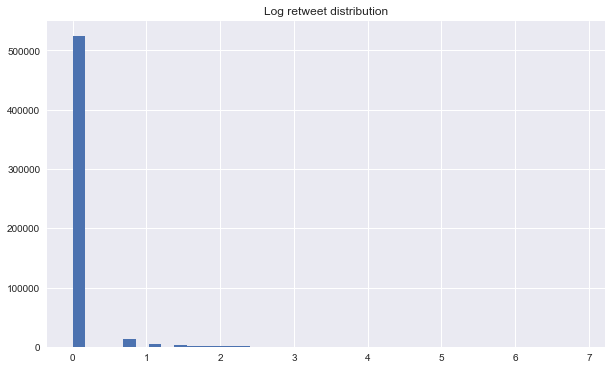

In [24]:
plt.figure(figsize=(10,6))
plt.hist(df_w_rt['log_retweets'], bins=40)
plt.title('Log retweet distribution')
plt.show()

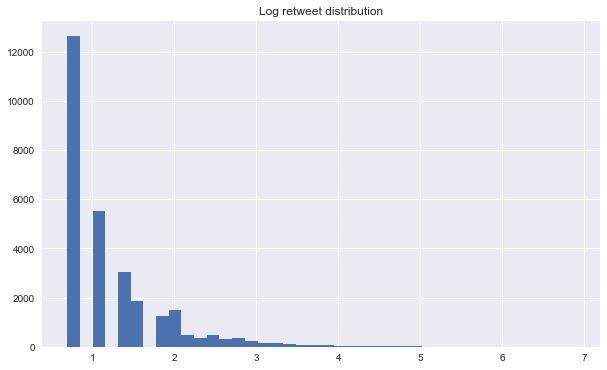

In [25]:
plt.figure(figsize=(10,6))
plt.hist(df_w_rt[df_w_rt['log_retweets']>0]['log_retweets'], bins=40)
plt.title('Log retweet distribution')
plt.show()

In [26]:
df_w_rt['engagement_flag']=df_w_rt['retweets']>0
df_w_rt['engagement_flag']=df_w_rt['engagement_flag'].astype(int)

## Tokenizing pared-down dataframe

In [27]:
df_base= df_w_rt[['user.description', 'text', 'topic', 'log_followers', 'log_retweets', 'engagement_flag']]

In [28]:
from gensim import corpora
from gensim.models import Phrases
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import islice
from sklearn.feature_extraction.text import TfidfTransformer

In [29]:
porter_stemmer = PorterStemmer()
tokenizer = TweetTokenizer()
#df_base['text_token'] = df_base.text.copy()
df_base['text_token'] = df_base["text"].apply(tokenizer.tokenize)
df_base['text_token'] = df_base['text_token'].apply(lambda x: [unicode(y.encode("utf-8"), errors='ignore') for y in x])
df_base['text_stemmed'] = df_base["text_token"].apply(lambda x: [porter_stemmer.stem(y) for y in x])

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

In [30]:
df_base['text_stemmed'] = df_base.loc[:,"text_stemmed"].apply(lambda x: [filter(None, y) for y in x])
df_base['text_processed'] = df_base.loc[:,'text_stemmed'].apply(' '.join)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [31]:
df_base.head()

,user.description,text,topic,log_followers,log_retweets,engagement_flag,text_token,text_stemmed,text_processed
0,"Part of the #VastRightWingConspiracy -- thanks, @HillaryClinton. Better candidate: https://www.randpaul.com/ Retweeting not endorsement. Image: TV lover.","#BanTheBox means ""all is #forgiven""/NO MORE federal #NCIC checks when buying guns? Please consider it, Mr. President @POTUS. #forgiving",G,5.252273,0.0,0,"[#BanTheBox, means, "", all, is, #forgiven, "", /, NO, MORE, federal, #NCIC, checks, when, buying, guns, ?, Please, consider, it, ,, Mr, ., President, @POTUS, ., #forgiving]","[#banthebox, mean, "", all, is, #forgiven, "", /, NO, more, feder, #ncic, check, when, buy, gun, ?, pleas, consid, it, ,, Mr, ., presid, @potu, ., #forgiv]","#banthebox mean "" all is #forgiven "" / NO more feder #ncic check when buy gun ? pleas consid it , Mr . presid @potu . #forgiv"
1,War Veteran who loves his country. Never forget those who died in 'Benghazi'. 864th Engineer Battalion (Combat) (Heavy),BOYCOTT NOV 4 @ABC @CMAwards &gt; THREAT TO ALL GUN OWNERS - BOYCOTT HIS MUSIC &gt; @TheTimMcGraw GUN CONTROL EXTREMIST https://t.co/xMuE2o7vV7 …,G,9.936148,0.0,0,"[BOYCOTT, NOV, 4, @ABC, @CMAwards, >, THREAT, TO, ALL, GUN, OWNERS, -, BOYCOTT, HIS, MUSIC, >, @TheTimMcGraw, GUN, CONTROL, EXTREMIST, https://t.co/xMuE2o7vV7, ]","[boycott, nov, 4, @abc, @cmaward, >, threat, TO, all, gun, owner, -, boycott, hi, music, >, @thetimmcgraw, gun, control, extremist, https://t.co/xmue2o7vv7, ]",boycott nov 4 @abc @cmaward > threat TO all gun owner - boycott hi music > @thetimmcgraw gun control extremist https://t.co/xmue2o7vv7
2,"Retired: cowboy,truck driver Served in the USAF, hobbies include Shooting sports and hunt and camp born in Calif.and sadly left in 1984","Savage: This is the Most Corrupt, Degenerate, Criminal Gov’t in American History https://t.co/qW12kzuBWH Take my guns lead first.",G,4.043051,0.0,0,"[Savage, :, This, is, the, Most, Corrupt, ,, Degenerate, ,, Criminal, Gov, , t, in, American, History, https://t.co/qW12kzuBWH, Take, my, guns, lead, first, .]","[savag, :, thi, is, the, most, corrupt, ,, degener, ,, crimin, gov, , t, in, american, histori, https://t.co/qw12kzubwh, take, my, gun, lead, first, .]","savag : thi is the most corrupt , degener , crimin gov t in american histori https://t.co/qw12kzubwh take my gun lead first ."
3,Bartender...Bouncer...Autobody......Gravedigger.....Supermodal......OG.....Playboy.........:)\r\n\r\n\r\nDAM...NICE...GUY...MAFIA DEMOLITION INSTALATION,Guns N' Roses - November Rain https://t.co/w2pHuG0QBa via @YouTube,G,6.107023,0.0,0,"[Guns, N, ', Roses, -, November, Rain, https://t.co/w2pHuG0QBa, via, @YouTube]","[gun, N, ', rose, -, novemb, rain, https://t.co/w2phug0qba, via, @youtub]",gun N ' rose - novemb rain https://t.co/w2phug0qba via @youtub
4,Ming doesn't have a trajectory problem.,"I'll say it again: #Tarantino was merely correct. And, to his credit, he's sticking to his rhetorical guns. #BadCops https://t.co/7M4uTpXwyc",G,5.081404,0.0,0,"[I'll, say, it, again, :, #Tarantino, was, merely, correct, ., And, ,, to, his, credit, ,, he's, sticking, to, his, rhetorical, guns, ., #BadCops, https://t.co/7M4uTpXwyc]","[i'll, say, it, again, :, #tarantino, wa, mere, correct, ., and, ,, to, hi, credit, ,, he', stick, to, hi, rhetor, gun, ., #badcop, https://t.co/7m4utpxwyc]","i'll say it again : #tarantino wa mere correct . and , to hi credit , he' stick to hi rhetor gun . #badcop https://t.co/7m4utpxwyc"


In [32]:
df_base.to_csv('cleaned.csv', sep=',', quotechar='"')

In [31]:
tvec = TfidfVectorizer(min_df=.0001, max_df=.2, stop_words='english', ngram_range=(1,2))
tvec_weights = tvec.fit_transform(df_base['text_processed'].dropna())
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})